In [1]:
import sys
import os
import time
import warnings
import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapz
from statsmodels.tsa.stattools import acf 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp

from plot_utils import *
from utils import *
from AnalyseDefects_dev import AnalyseDefects

## Set plotting style and print options
plt.style.use('sg_article')
np.set_printoptions(precision = 5, suppress=1e-10)

In [47]:
ad.Ndata

2

In [87]:
ad.Nactivity

[10, 7]

In [250]:
def extract_ahu_results(obj, save = True,):
    """
    Analyse the defects for all the input folders
    """
    for N in range(obj.Ndata):
        print(f'Processing data set {N+1}/{obj.Ndata}...')

        kbins = np.loadtxt(os.path.join(obj.output_paths[N], 'kbins.txt'))
        rad = np.load(os.path.join(obj.output_paths[N], 'rad.npy'))

        sfac_full = np.nan * np.zeros((obj.Nframes[N], len(kbins), 2, obj.Nactivity[N], min(10, obj.Nexp[N])))
        sfac_pp = np.nan * np.zeros_like(sfac_full)
        sfac_mm = np.nan * np.zeros_like(sfac_full)
        sfac_pm = np.nan * np.zeros_like(sfac_full)

        pcf_full = np.nan * np.zeros((obj.Nframes[N], len(rad), obj.Nactivity[N], min(obj.Nexp[N], 10)))
        pcf_pp = np.nan * np.zeros_like(pcf_full)
        pcf_mm = np.nan * np.zeros_like(pcf_full)
        pcf_pm = np.nan * np.zeros_like(pcf_full)


        print('Analyse defects for input folder {}'.format(obj.input_paths[N]))
        for i, (act, act_dir) in enumerate(zip(obj.act_list[N], obj.act_dir_list[N])):
            print(f'Activity {i+1}/{obj.Nactivity[N]}: {act}')
            sfac_counter = 0
            exp_list = []
            exp_dir_list = []

            for file in os.listdir(act_dir):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir, file))

            # sort the activity list and the activity directory list
            exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

            for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
      
                if sfac_counter < 10:
                    try:
                        sfac_full[-obj.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'sfac.npy'))[-obj.Nframes[N]:, :,:]
                        sfac_pp[-obj.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'sfac_pos.npy'))[-obj.Nframes[N]:, :,:]
                        sfac_mm[-obj.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'sfac_neg.npy'))[-obj.Nframes[N]:, :,:]
                    except:
                        print(f'Error loading sfac for activity {act}, experiment {exp}. Skipping...')
                    try:
                        pcf_full[-obj.Nframes[N]:, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'pcf_arr.npy'))[-obj.Nframes[N]:, :,]
                        pcf_pp[-obj.Nframes[N]:, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'pcf_arr_pos.npy'))[-obj.Nframes[N]:, :,]
                        pcf_mm[-obj.Nframes[N]:, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'pcf_arr_neg.npy'))[-obj.Nframes[N]:, :,]
                        
                    except:
                        pass
                    if os.path.isfile(os.path.join(exp_dir,'sfac_analysis_completed.txt')):
                        sfac_counter += 1

        pcf_pm = 2 * pcf_full - pcf_pp - pcf_mm
        sfac_pm = sfac_full - 1/2 * (sfac_pp + sfac_mm)

        if save:
            np.save(os.path.join(obj.output_paths[N], 'sfac_full.npy'), sfac_full)
            np.save(os.path.join(obj.output_paths[N], 'sfac_pp.npy'), sfac_pp)
            np.save(os.path.join(obj.output_paths[N], 'sfac_mm.npy'), sfac_mm)
            np.save(os.path.join(obj.output_paths[N], 'sfac_pm.npy'), sfac_pm)
            np.save(os.path.join(obj.output_paths[N], 'pcf_full.npy'), pcf_full)
            np.save(os.path.join(obj.output_paths[N], 'pcf_pp.npy'), pcf_pp)
            np.save(os.path.join(obj.output_paths[N], 'pcf_mm.npy'), pcf_mm)
            np.save(os.path.join(obj.output_paths[N], 'pcf_pm.npy'), pcf_pm)
    return

def calc_time_av(obj, Ndataset, data_arr, temp_corr_arr, \
                    temp_corr_simple = True, ddof = 1, save_name = None,):
    """
    data_arr must have shape (Nframes, Nsomething, Nact, Nexp)
    returns an array of shape (Nsomething, Nact, 2)
    """

    Nframes, Nsomething, Nact, Nexp = data_arr.shape
    N = Ndataset
    time_av = np.nan * np.zeros((Nsomething, Nact, 2))
    
    for i in range(Nact):
        ff_idx = obj.conv_list[N][i]

        Nsamples = (Nframes - ff_idx) * np.ones((Nsomething, Nexp)) - np.nansum(np.isnan(data_arr[ff_idx:, :, i, :]),axis=(0))
        Nind_samples = np.nansum(Nsamples / temp_corr_arr[1 if temp_corr_simple else 0, :, i, :,], axis = -1)
    
        time_av[:, i, 0]  = np.nanmean(data_arr[obj.conv_list[N][i]:, :, i, :], axis = (0, -1))
        time_av[:, i, 1] = np.nanstd(data_arr[obj.conv_list[N][i]:, :, i, :], axis = (0, -1), ddof = ddof) / np.sqrt(Nind_samples)
    
    if save_name is not None:
        np.save(os.path.join(obj.output_paths[N], save_name + '.npy'), time_av)
        return
    else:
        return time_av

if 0:
    def __calc_sfac_pcf(self, Ndataset = 0, acf_dict = {}, temp_corr_simple = True, ddof = 1, calculate_pcf = True,):
        
        N = Ndataset

        if not self.ext_sfac:
            print('kbins.txt not found. Assuming structure factor not extracted.')
            return
        if not os.path.isfile(os.path.join(self.output_paths[N], 'sfac.npz')):
            print('Structure factor not found. Extract results first.')
            return
        
        sfac_path = os.path.join(self.output_paths[N], 'sfac.npz')
        sfac_npz = np.load(sfac_path, 'sfac.npz', allow_pickle = True)
        sfac, sfac_err = sfac_npz['sfac'], sfac_npz['sfac_err']
        sfac_dict = dict(sfac_npz)

        Nframes, Nkbins, Nact, Nexp = sfac.shape[:]
        sfac_time_av = np.nan * np.zeros((Nkbins, Nact, 2))

        self.__calc_av_over_exp(sfac, N, save_name = 'sfac_av',)

        sfac_temp_corr = self.est_corr_time(sfac_dict, npz_target_name='sfac', \
                                            npz_path = sfac_path, Ndataset = N, \
                                            acf_dict = acf_dict, use_error_bound = False)
        
        for i in range(Nact):
            ff_idx = self.conv_list[N][i]

            Nsamples = (Nframes - ff_idx) * np.ones((Nkbins, Nexp)) - np.nansum(np.isnan(sfac[ff_idx:, :, i, :]),axis=(0))
            Nind_samples = np.nansum(Nsamples / sfac_temp_corr[1 if temp_corr_simple else 0, :, i, :,], axis = -1)

            #print(sfac_temp_corr, Nsamples, Nind_samples)

            sfac_mean_err = np.nanmean(sfac_err[self.conv_list[N][i]:, :, i, :], axis = (0, -1)) 
            sfac_time_av[:, i, 0]  = np.nanmean(sfac[self.conv_list[N][i]:, :, i, :], axis = (0, -1))
            sfac_time_av[:, i, 1] = (sfac_mean_err + np.nanstd(sfac[self.conv_list[N][i]:, :, i, :], axis = (0, -1), ddof = ddof)) / np.sqrt(Nind_samples)

            # print(sfac_mean_err, np.nanstd(sfac[self.conv_list[N][i]:, :, i, :], axis = (0, -1), ddof = ddof))

        np.save(os.path.join(self.output_paths[N], 'sfac_time_av.npy'), sfac_time_av)

        if calculate_pcf and self.ext_pcf:
            if not os.path.isfile(os.path.join(self.output_paths[N], 'pcf.npz')):
                print('Structure factor not found. Extract results first.')
                return

            pcf_path = os.path.join(self.output_paths[N], 'pcf.npz')
            pcf = np.load(pcf_path, 'pcf.npz', allow_pickle=True)['pcf']
            pcf_dict = dict(np.load(pcf_path, allow_pickle = True))

            self.__calc_av_over_exp(pcf, N, return_arr = False, save_name = 'pcf_av', save = True)
            pcf_temp_corr = self.est_corr_time(pcf_dict, npz_target_name='pcf', \
                                            npz_path = pcf_path, Ndataset = N, \
                                            acf_dict = acf_dict, use_error_bound = False)       
            self.__calc_time_av(N, pcf, pcf_temp_corr, temp_corr_simple = temp_corr_simple, ddof = ddof, save_name = 'pcf_time_av',)  
        return

In [254]:
LL = 2048

input_suffix = 'cs'
output_path_ref = f'data\\na{LL}'
output_path_new = f'data\\na{LL}{input_suffix}'
mode = 'all' # 'all' or 'short'

suffix_list = ['_full', '_pp', '_mm', '_pm']

defect_list = gen_analysis_dict(LL, mode)

for i in range(len(defect_list)):
    defect_list[i]['path'] = defect_list[i]['path'] + input_suffix
 
ad = AnalyseDefects(defect_list, output_path=output_path_new)

extract, analyze, merge = False, False, False


if extract:
    extract_ahu_results(ad, save=True)
if analyze:

    temp_corr_simple = True
    Nexp  = 5
    ddof = 1

    for i in range(ad.Ndata): 
        sfac_time_corr_arr = np.load(os.path.join(ad.output_paths[i], 'sfac.npz'))['corr_time_arr'][:, :, :, :Nexp]
        pcf_time_corr_arr = np.load(os.path.join(ad.output_paths[i], 'pcf.npz'))['corr_time_arr'][:, :, :, :Nexp]
        for j, suffix in enumerate(suffix_list):
            sfac_arr = np.load(os.path.join(ad.output_paths[i], 'sfac' + suffix + '.npy'))[:, :, 0, :, :]
            pcf_arr = np.load(os.path.join(ad.output_paths[i], 'pcf' + suffix + '.npy'))

            _ = calc_time_av(ad, i, sfac_arr, \
                                        sfac_time_corr_arr, temp_corr_simple = temp_corr_simple, ddof = ddof, \
                                        save_name = 'sfac_time_av' + suffix)
            _ = calc_time_av(ad, i, pcf_arr, \
                                        pcf_time_corr_arr, temp_corr_simple = temp_corr_simple, ddof = ddof, \
                                        save_name = 'pcf_time_av' + suffix) 
if merge:
    kbins, _, rad = ad.get_sfac_pcf()[:3]
    act_list = ad.act_list_merged

    Nact, Nkbins, Nrad = len(act_list), len(kbins), len(rad)
    Nact_min, Nact_max = 0, 0

    for j, suffix in enumerate(suffix_list):
        sfac_tav_merged = np.nan * np.zeros((Nkbins, Nact, 2))
        pcf_tav_merged = np.nan * np.zeros((Nrad, Nact, 2))
   
        Nact_min, Nact_max = 0, 0
        for i in reversed(range(ad.Ndata)):
            Nact_max += ad.Nactivity[i]

            sfac_tav_merged[:, Nact_min:Nact_max, :] = np.load(os.path.join(ad.output_paths[i], 'sfac_time_av' + suffix + '.npy')) #np.load(os.path.join(ad.output_paths[i], 'sfac_time_av' + suffix + '.npy'))
            pcf_tav_merged[:, Nact_min:Nact_max, :] = np.load(os.path.join(ad.output_paths[i], 'pcf_time_av' + suffix + '.npy'))
            Nact_min += ad.Nactivity[i]
        np.save(os.path.join(ad.output_merged, 'sfac_time_av_merged' + suffix + '.npy'), sfac_tav_merged) 
        np.save(os.path.join(ad.output_merged, 'pcf_time_av_merged' + suffix + '.npy'), pcf_tav_merged)
else:
    act_list_merged = ad.act_list_merged
    kbins, _, rad = ad.get_sfac_pcf()[:3]
    sf_full = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_full.npy'))
    sf_pp = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_pp.npy'))
    sf_mm = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_mm.npy'))
    sf_pm = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_pm.npy'))
    pcf_full = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_full.npy'))
    pcf_pp = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_pp.npy'))
    pcf_mm = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_mm.npy'))
    pcf_pm = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_pm.npy'))

    pcf_pm_post = 2 * pcf_full - pcf_pp - pcf_mm
    sf_pm_post = sf_full - 1/2 * (sf_pp + sf_mm)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11124\3542263250.py:73: RuntimeWarning: invalid value encountered in subtract
  pcf_pm_post = 2 * pcf_full - pcf_pp - pcf_mm
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11124\3542263250.py:74: RuntimeWarning: invalid value encountered in subtract
  sf_pm_post = sf_full - 1/2 * (sf_pp + sf_mm)


In [255]:
def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]

    return x, Y0 * x**scaling_exp / x[0]**scaling_exp


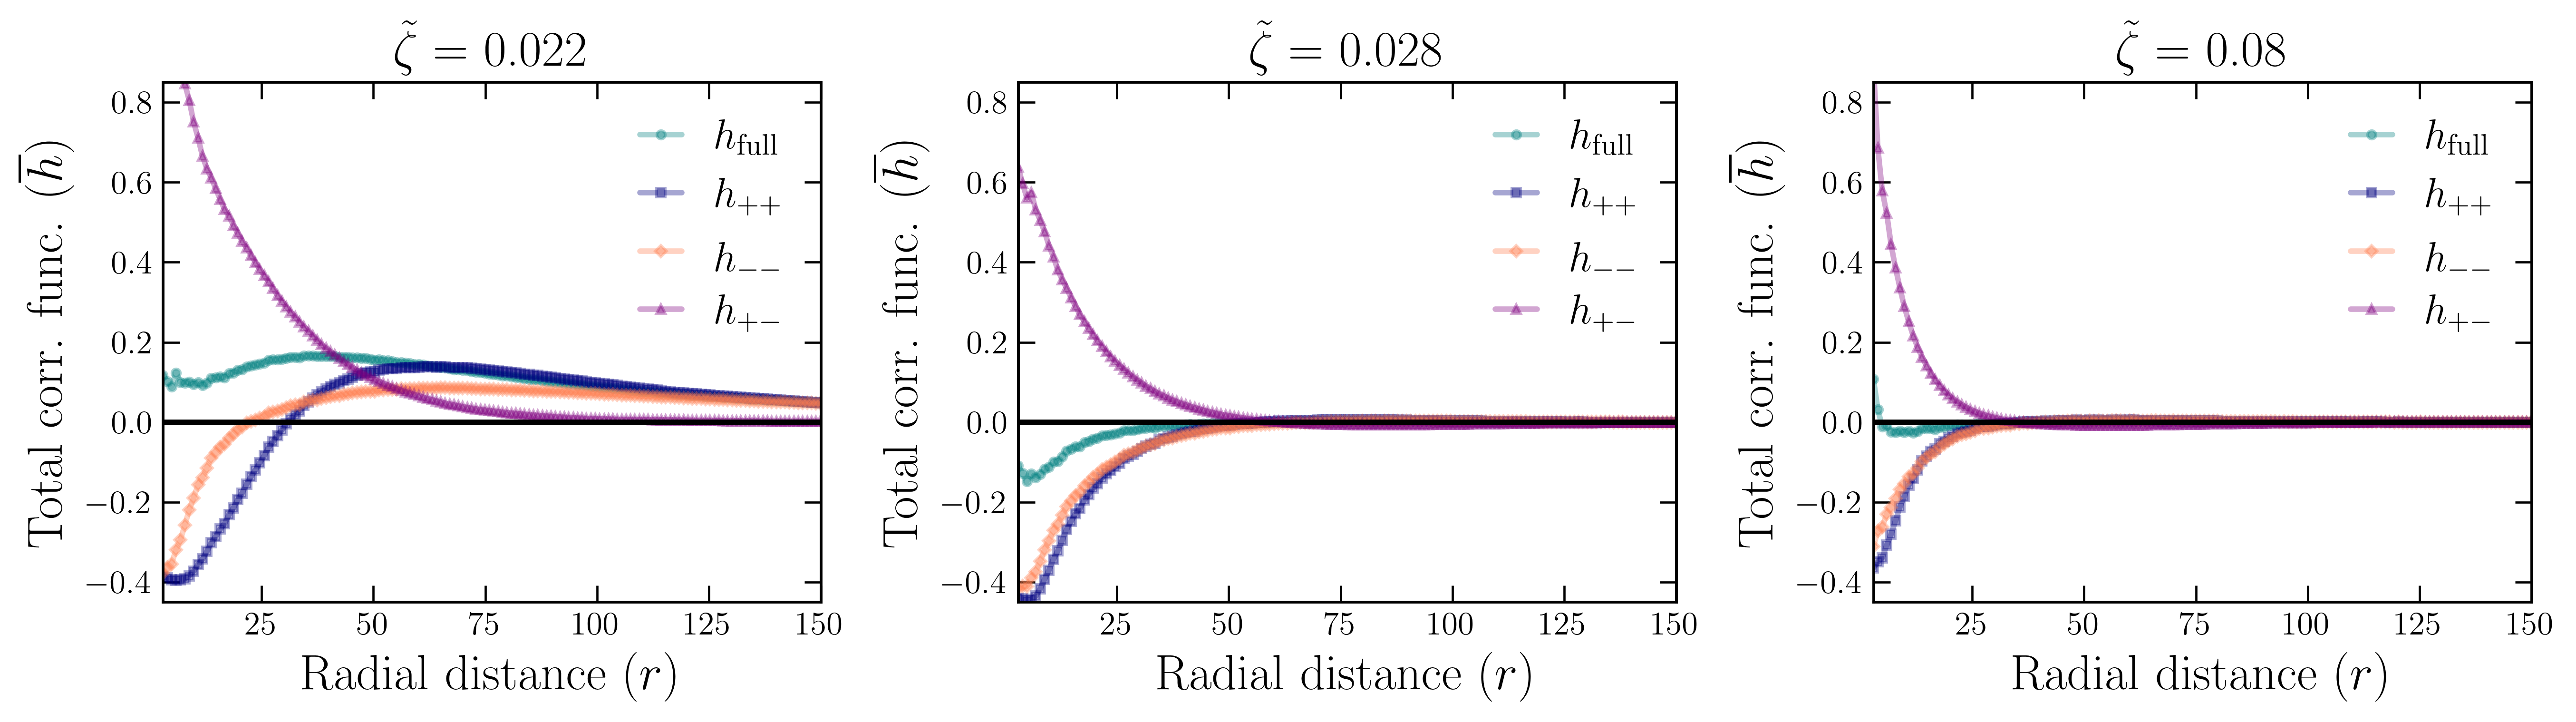

In [ ]:
plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})

act_list = [0.022, 0.028, 0.08]

marker_list = ['o', 's', 'D', '^', 'v', 'x', 'p', '*', 'h', '+']

kbins_min = 3

nrows = 1
width=13
height = width / 3.5 * nrows
fig0, ax0 = plt.subplots(nrows = nrows, ncols=3, figsize=(width, height))
ax0 = ax0.flatten()
kwargs = {'markersize': 3, 'alpha': .35}

for i, ax in enumerate(ax0):
    act_idx = np.where(act_list_merged == act_list[i])[0][0]
    ax.set_title(rf'$\tilde \zeta$ = {act_list_merged[act_idx]}')
    ax.set_ylabel(r'Total corr. func. ($\overline h$)')
    ax.set_xlabel(r'Radial distance $(r)$')
    ax.plot(rad[ridx_min:], pcf_full[ridx_min:,act_idx,0]-1, label = r'$h_{\mathrm{full}}$', marker = marker_list[0], **kwargs)
    ax.plot(rad[ridx_min:], pcf_pp[ridx_min:,act_idx,0]-1, label =  r'$h_{++}$', marker = marker_list[1], **kwargs)
    ax.plot(rad[ridx_min:], pcf_mm[ridx_min:,act_idx,0]-1, label = r'$h_{-{-}}$', marker = marker_list[2], **kwargs)
    ax.plot(rad[ridx_min:], pcf_pm[ridx_min:,act_idx,0], label = r'$h_{+-}$', marker = marker_list[3], **kwargs)

    xvals, yvals = produce_scaling(rad, -1.1, .025, (200, 450))
    #ax.plot(xvals, yvals, label = r'$h_{+-} \sim r^{-2}$', color = 'k', linestyle = '--')
    ax.legend()
    ax.hlines(0, rad[ridx_min], rad[-1], colors='k', linestyles='solid')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(-.45, .85)
    ax.set_xlim(xmin=3, xmax=150)#rad[-1])


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11124\472283093.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin=0, xmax=kbins[-1]+.1)


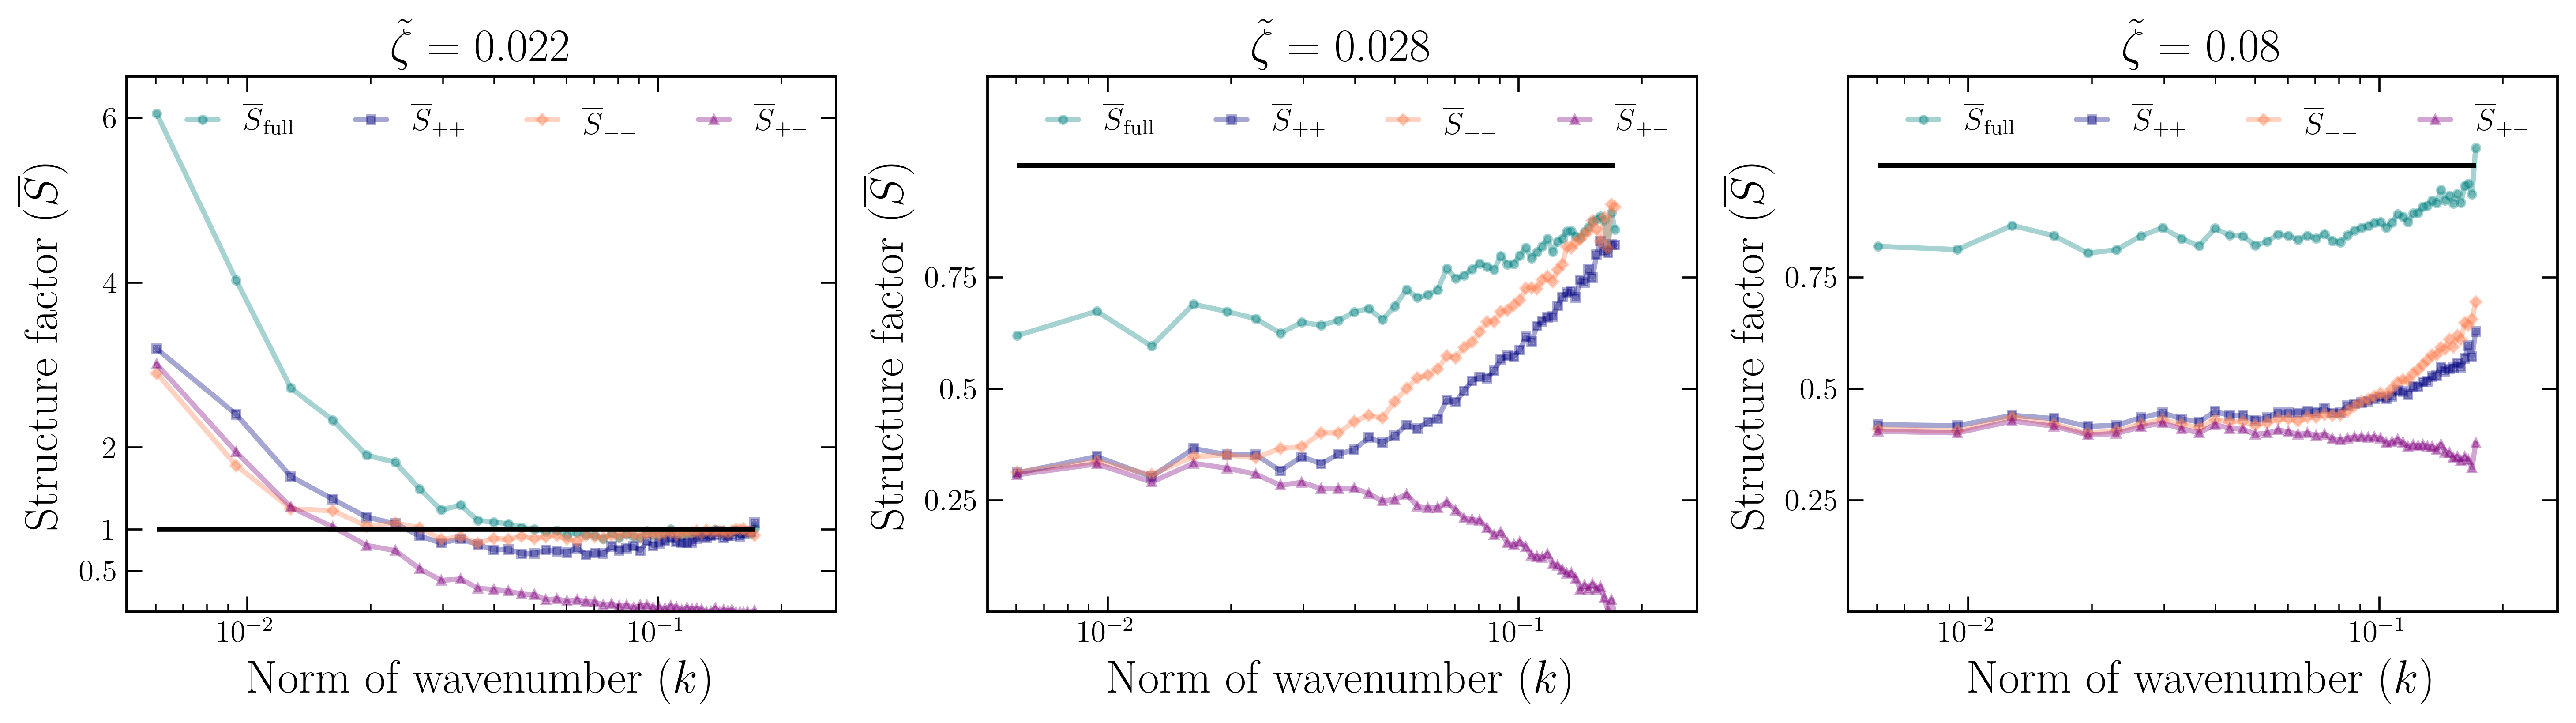

In [283]:
plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})

act_list = [0.022, 0.028, 0.08]

marker_list = ['o', 's', 'D', '^', 'v', 'x', 'p', '*', 'h', '+']

kbins_min = 0

nrows = 1
width=14
height = width / 3.5 * nrows
fig0, ax0 = plt.subplots(nrows = nrows, ncols=3, figsize=(width, height))
ax0 = ax0.flatten()
kwargs = {'markersize': 3, 'alpha': .35}

for i, ax in enumerate(ax0):
    act_idx = np.where(act_list_merged == act_list[i])[0][0]
    ax.set_title(rf'$\tilde \zeta$ = {act_list_merged[act_idx]}')
    ax.set_ylabel(r'Structure factor ($\overline S$)')
    ax.set_xlabel(r'Norm of wavenumber $(k)$')
    ax.plot(kbins[kbins_min:], sf_full[kbins_min:,act_idx,0], label = r'$\overline S_{\mathrm{full}}$', marker = marker_list[0], **kwargs)
    ax.plot(kbins[kbins_min:], sf_pp[kbins_min:,act_idx,0], label =  r'$\overline S_{++}$', marker = marker_list[1], **kwargs)
    ax.plot(kbins[kbins_min:], sf_mm[kbins_min:,act_idx,0], label = r'$\overline S_{-{-}}$', marker = marker_list[2], **kwargs)
    ax.plot(kbins[kbins_min:], sf_pm_post[kbins_min:,act_idx,0], label = r'$\overline S_{+-}$', marker = marker_list[3], **kwargs)

    xvals, yvals = produce_scaling(rad, -1.1, .025, (200, 450))
    #ax.plot(xvals, yvals, label = r'$h_{+-} \sim r^{-2}$', color = 'k', linestyle = '--')
    ax.legend(ncols=4,loc='upper right', fontsize=12)
    ax.hlines(1, kbins[kbins_min], kbins[-1], colors='k', linestyles='solid')

    ax.set_xscale('log')
    #ax.set_yscale('log')

    yticks = []
    ax.set_yticks(yticks, yticks)

    yticks = [0.5, 1, 2, 4, 6] if i == 0 else [0.25, 0.5, 0.75,]
    ax.set_yticks(yticks, yticks)

    ax.set_xlim(xmin=0, xmax=kbins[-1]+.1)
    ax.set_ylim(ymin=0.5 if i == 0 else 0.25, ymax=6.5 if i == 0 else 1.2)
    ax.set_ylim(ymin=0)
   # ax.set_xscale('log')
    #ax.set_yscale('log')


In [276]:
ax.get_yticks()

array([0.25, 0.5 , 0.75])

In [ ]:

axx.set_ylabel(r'Structure factor ($\overline{S}$)')
axx.hlines(1, 0, 0.4, color = 'k', linestyle='--', lw=1.5)
axx.set_ylim([0.3, 7])
axx.set_xlim([0.005,0.18])
axx.legend(loc='upper right', ncol=2)
klabel_list = [r'$k_{min}$(L=256)', r'$k_{min}$(L=512)', r'$k_{min}$(L=1024)']
for i, kmin in enumerate(kmin_list[:-1]):
    axx.vlines(kmin, 0.3, .33, color = 'k', linestyle='-', lw=1.5)
    axx.text(kmin, 0.33, klabel_list[i], fontsize=12.5, verticalalignment='bottom', horizontalalignment='center')
#axx.text(0.7, 0.2, r'L = 1024', transform=axx.transAxes, fontsize=16, verticalalignment='top', fontweight='normal')
#axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

act_idx = ada.act_list[ada.LX.index(2048)].index(0.028)
x = kbins[1:50]
x2 = kbins[0:14]
scaling_exp = .2
scaling_exp2 = .1
axx.plot(x, (sfac_av[-1,act_idx,0]-0.00) * x**scaling_exp / x[-1]**scaling_exp, '--',lw=2, alpha=.8, color='blue')
axx.plot(x2, (sfac_av[len(x2),act_idx,0]+0.0) * x2**scaling_exp2 / x2[-1]**scaling_exp2, '--',lw=2, alpha=.8, color='green')
axx.legend(ncol=3)

axx.text(0.0145, 3.3, r'$\sim k^{-0.93}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
axx.text(0.0058, 0.8, r'$\sim k^{0.03}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
axx.text(0.0058, 0.52, r'$\sim k^{0.1}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
axx.text(0.02, 0.54, r'$\sim k^{0.2}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')

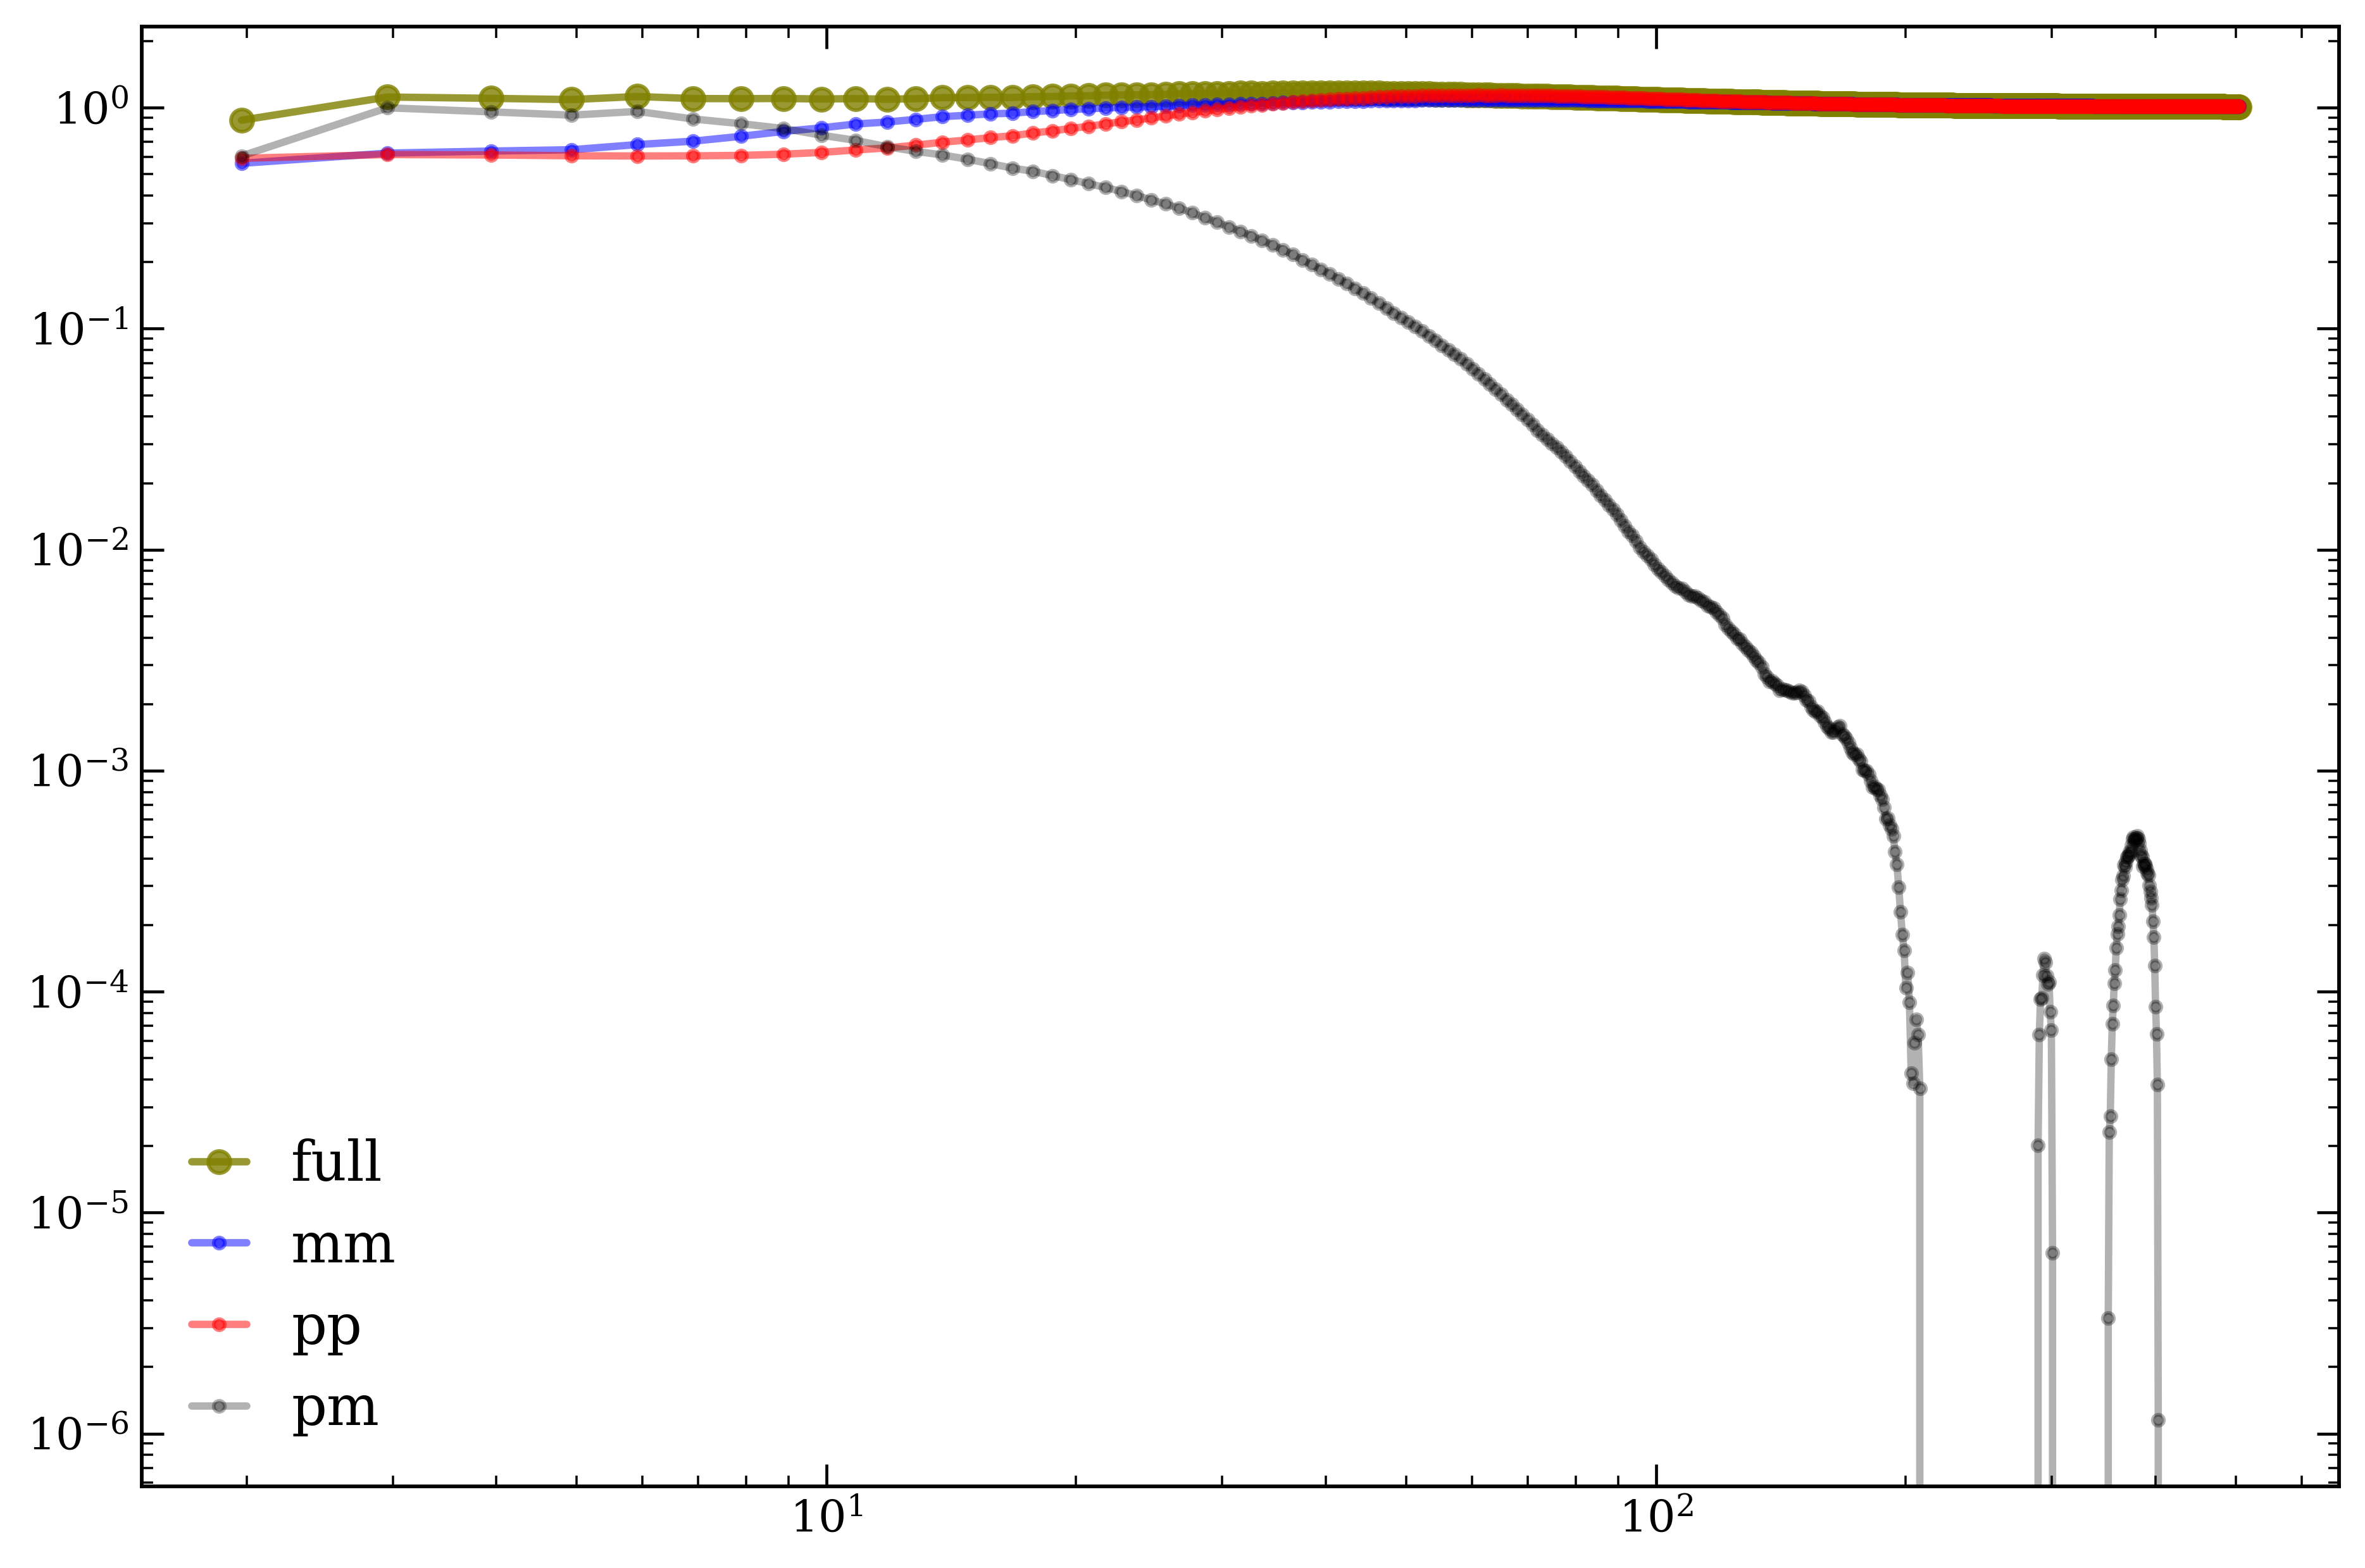

In [124]:
act = 0.022
act_idx = np.argwhere(np.array(act_list) == act)[0][0]
normalize = False
normalize_with_abs = False
plot_abs_val = False
shift = False

shift_val = 1 if shift else 0
rfidx= np.argwhere(rad > 1)[0][0]

norm_full = np.abs(pcf_full[1, act_idx, 0]) if normalize_with_abs else pcf_full[1, act_idx, 0]
norm_full = np.abs(pcf_mm[1,act_idx, 0]) if normalize_with_abs else pcf_mm[1,act_idx, 0]
norm_full = np.abs(pcf_pp[1,act_idx, 0]) if normalize_with_abs else pcf_pp[1,act_idx, 0]

#pcf_pm_post = 2 * pcf_full[:,0] - pcf_pp[:,0] - pcf_mm[:,0]
norm_full = 1 #pcf_pm_post[rfidx]

if normalize is False:
    norm_full = 1
    norm_full = 1
    norm_full = 1
    norm_full = 1

prefactor = 1
#pcf_pm_post = (pcf_full.pcf - pcf_pm.pcf - pcf_pp.pcf)
fig, ax = plt.subplots()

y_full = np.abs(pcf_full[rfidx:,act_idx, 0] / norm_full - shift) if plot_abs_val else pcf_full[rfidx:,act_idx, 0] / norm_full - shift
y_pm = np.abs(prefactor * pcf_mm[rfidx:,act_idx, 0] / norm_full - shift) if plot_abs_val else prefactor * pcf_mm[rfidx:,act_idx, 0] / norm_full - shift
y_pp = np.abs(prefactor * pcf_pp[rfidx:, act_idx, 0] / norm_full - shift) if plot_abs_val else prefactor * pcf_pp[rfidx:, act_idx,  0] / norm_full - shift
y_ppm = np.abs(prefactor * pcf_pm_post[rfidx:,act_idx, 0] / norm_full ) if plot_abs_val else prefactor * pcf_pm_post[rfidx:, act_idx, 0] / norm_full 

ax.plot(rad[rfidx:], y_full, 'o-', color='olive', alpha=.8, label='full')
#ax.plot(pcf_pm.r.values, prefactor * pcf_pm.pcf / pcf_pm.pcf[1], '.-', color='blue', alpha=.5, label='mm')
#ax.plot(pcf_pp.r.values, prefactor * pcf_pp.pcf / pcf_pp.pcf[1], '.-', color='red', alpha=.5, label='pp')
ax.plot(rad[rfidx:], y_pm,  '.-', color='blue', alpha=.5, label='mm')
ax.plot(rad[rfidx:], y_pp, '.-', color='red', alpha=.5, label='pp')
ax.plot(rad[rfidx:], y_ppm, '.-', color='black', alpha=.3, label='pm')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

(2, 50, 10, 5) (2, 513, 10, 5)
(181, 50, 10, 5) (181, 513, 10, 5)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11124\2318018014.py:88: RuntimeWarning: divide by zero encountered in divide
  time_av[:, i, 1] = np.nanstd(data_arr[obj.conv_list[N][i]:, :, i, :], axis = (0, -1), ddof = ddof) / np.sqrt(Nind_samples)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11124\2318018014.py:87: RuntimeWarning: Mean of empty slice
  time_av[:, i, 0]  = np.nanmean(data_arr[obj.conv_list[N][i]:, :, i, :], axis = (0, -1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(181, 50, 10, 5) (181, 513, 10, 5)
(181, 50, 10, 5) (181, 513, 10, 5)
(181, 50, 10, 5) (181, 513, 10, 5)
(2, 50, 7, 5) (2, 513, 7, 5)
(400, 50, 7, 5) (400, 513, 7, 5)
(400, 50, 7, 5) (400, 513, 7, 5)
(400, 50, 7, 5) (400, 513, 7, 5)
(400, 50, 7, 5) (400, 513, 7, 5)


In [ ]:
extract_ahu_results(ad, save=True,)